# Sparkify Project Workspace on IBM Watson Studio (for medium size data)
This is a notebook for medium size dataset of Sparkify project worked on IBM Watson Studo.<br>
This note is mainly focusing on preprocessing and modeling steps in order to verify those pipelines scripts actually work with parallel computing on Spark cluster.<br>
For other steps, such as 'data exploratory analysis' and 'summary and conclusion', please refer to mini dataset note.

In [1]:
# import libraries
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc as Fauc
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType, StringType
from pyspark.sql.functions import col, udf, asc, desc, min, max, count, avg, stddev_pop, countDistinct, last, first, when
from pyspark.sql.functions import isnan, lit, greatest, round
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoderEstimator, StandardScaler, SQLTransformer
from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190303013427-0000
KERNEL_ID = f096b7fb-bede-4903-996e-276c0763a47d


# Load and Clean Dataset
In this workspace, the medium-dataset file is `medium_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [2]:
from pyspark.sql import SparkSession
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.ap-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-b7451128-76da-4d1f-91f7-ea9cfa95a0c3',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': '1Eto0p8TixF0d9hXWPtvjNO0GhIqHOHny7jxWW3XW6SZ'
}

configuration_name = 'os_46057101a85342f0a2ce2402774f675b_configs'
cos = ibmos2spark.CloudObjectStorage(
    sc, credentials, configuration_name, 'bluemix_cos')

spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

data = spark.read.json(cos.url(
    'medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-pyag0kzbec47t2'))
# df_data_1.take(5)

In [3]:
# check contents
data.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

---
### Data Cleaning

The script is in form of transformer in order to combine with label definition and feature engineering steps and put into one pipeline.<br>
>PS: There is a feedback from feature engineering step and we also have to exclude rows of users who have only 1 song play count or less. The procedure is added into the end of script.

In [93]:
# Data Cleaner (subroutine)
def add_data_cleaner():
    '''
    OUTPUT:
    stages - (list) list of transformer to be used as 'stages' argument of pyspark Pipeline() constructor

    DESCRIPTION:
    This is a subroutine of create_preprocess_pipeline() function.
    Stages added by this function will clean raw pyspark dataframe for next steps.
    '''
    stages = []  # pipeline stage list

    # filter rows with userId==Null or sessionId==Null, just in case
    sqlTrans = SQLTransformer(
        statement="SELECT * FROM __THIS__ WHERE userId IS NOT NULL AND sessionId IS NOT NULL")
    stages.append(sqlTrans)

    # drop empty user id row
    sqlTrans = SQLTransformer(
        statement="SELECT * FROM __THIS__ WHERE userId != ''")
    stages.append(sqlTrans)

    # drop 'Logged-Out' state and 'Guest' state
    sqlTrans = SQLTransformer(
        statement="SELECT * FROM __THIS__ WHERE auth != 'Logged Out' AND auth != 'Guest'")
    stages.append(sqlTrans)

    # exclude rows with user who has only one song play or less
    sqlTrans = SQLTransformer(statement=" \
        SELECT * \
        FROM __THIS__ \
        WHERE userId NOT IN ( \
            SELECT DISTINCT userId \
            FROM \
            (SELECT userId, page, \
                COUNT(CASE WHEN page = 'NextSong' THEN page END) \
                OVER(PARTITION BY userId) AS songCount \
            FROM __THIS__) AS user_page_count \
            WHERE user_page_count.songCount < 2)")
    stages.append(sqlTrans)

    return stages

---
# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

---
### Label Definition

Label definition steps are combined into following script.<br>
The script is in form of transformer so that it can be combined with data cleaning and feature engineering steps and put into one pipeline.<br>

In [5]:
# Label Maker (subroutine)
def add_label_maker(stages):
    '''
    INPUT:
    stages - (list) list of transformer to be used as 'stages' argument of pyspark Pipeline() constructor
                It should be an output of 'create_data_cleaner()' function.

    OUTPUT:
    stages - (list) list of transformer to be used as 'stages' argument of pyspark Pipeline() constructor

    DESCRIPTION:
    This is a subroutine of create_preprocess_pipeline() function.
    Stages added by this function will make label column in target pyspark dataframe.
    It also drops rows which the label column directly depends on.
    '''
    # 'churn_event'
    # add a column to store churn event as integer
    sqlTrans = SQLTransformer(statement=" \
        SELECT *, \
            CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END AS churn_event \
        FROM __THIS__")
    stages.append(sqlTrans)

    # 'Churn'
    # add a column to store cumulative sum of churn flag
    sqlTrans = SQLTransformer(statement=" \
        SELECT *, \
            MAX(churn_event) OVER ( \
                PARTITION BY userId \
            ) AS Churn \
        FROM __THIS__")
    stages.append(sqlTrans)

    return stages

---
### Feature Exploration
Feature exploration section is omitted for medium size dataset.<br>
Please refer to mini size dataset note for feature exploration.

---
# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

---
**Dataset Contents**<br>
We will prepare following data by feature engineering.
* User ID: index
* Label: churned or not
* Features: 
    * song play event interval averaged for each user
    * event counts for other types of events, divided by total song count for each user
        * 'Cancel' and 'Cancellation Confirmation' events will be dropped from features.

---
**Structure of scripts**<br>
>* create_preprocess_pipeline() : Combine following three subroutines and create a pipeline of total data preprocessing.<br>
>>* add_data_cleaner() : Subroutine to add data cleaner stages in the pipeline. Shown earlier in Data Cleaning section.<br>
>>* add_label_maker(): Subroutine to add label maker stages in the pipeline. Shown earlier in Label Definition section.<br>
>>* add_features_maker() : Subroutine to add features maker stages in the pipeline.

In [98]:
# Feature Creater (subroutine)
def add_features_maker(stages):
    '''
    INPUT:
    stages - (list) list of transformer to be used as 'stages' argument of pyspark Pipeline() constructor
                It must be an output of 'create_label_maker()' function.

    OUTPUT:
    stages - (list) list of transformer to be used as 'stages' argument of pyspark Pipeline() constructor
    feature_labels - (list) list of feature column names for utility

    DESCRIPTION:
    This is a subroutine of create_preprocess_pipeline() function.
    Stages added by this function will make feature columns in target pyspark dataframe.
    '''
    # 'event_name'
    # replace whitespace of page column with underbar and put into a new column
    sqlTrans = SQLTransformer(statement=" \
        SELECT userId, Churn AS label, ts, registration, level, event_name \
        FROM ( \
            SELECT *, REPLACE(page, ' ', '_') AS event_name \
            FROM __THIS__)")

    stages.append(sqlTrans)

    # 'event_name' elements
    event_names = [
        'About',
        'Add_Friend',
        'Add_to_Playlist',
        # 'Cancel',
        # 'Cancellation_Confirmation',
        'Downgrade',
        'Error',
        'Help',
        'Home',
        'Logout',
        'NextSong',
        'Roll_Advert',
        'Save_Settings',
        'Settings',
        'Submit_Downgrade',
        'Submit_Upgrade',
        'Thumbs_Down',
        'Thumbs_Up',
        'Upgrade']

    # 'eventInterval'
    # add a column to store event intervals (in seconds)
    sqlTrans = SQLTransformer(statement=" \
        SELECT *, \
            ((FIRST_VALUE(ts) OVER ( \
                PARTITION BY userId, event_name \
                ORDER BY ts DESC \
                ROWS BETWEEN 1 PRECEDING AND CURRENT ROW \
            ) / 1000) - (LAST_VALUE(ts) OVER ( \
                PARTITION BY userId, event_name \
                ORDER BY ts DESC \
                ROWS BETWEEN 1 PRECEDING AND CURRENT ROW \
            ) / 1000)) AS eventInterval \
        FROM __THIS__")

    stages.append(sqlTrans)

    # 'lastTS'
    # add a column to store the last TS for each user
    sqlTrans = SQLTransformer(statement=" \
        SELECT *, \
            (FIRST_VALUE(ts) OVER ( \
                PARTITION BY userId, event_name \
                ORDER BY ts DESC \
                ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW \
            )) AS lastTS \
        FROM __THIS__")

    stages.append(sqlTrans)

    # 'trueInterval'
    # set the last TS row's interval value to Null
    sqlTrans = SQLTransformer(statement=" \
        SELECT *, \
            CASE WHEN ts == lastTS THEN NULL ELSE eventInterval END AS trueInterval \
        FROM __THIS__")

    stages.append(sqlTrans)

    # 'trueInterval'(update), 'pageCount', 'paidCount', 'songCount'
    # group by userId and page
    # we get average of interval for NextSong, and count for other events
    # we also count paid songs, and total songs
    sqlTrans = SQLTransformer(statement=" \
        SELECT label, userId, event_name, \
            AVG(trueInterval) AS trueInterval, \
            COUNT(event_name) AS pageCount, \
            COUNT(CASE WHEN event_name = 'NextSong' AND level = 'paid' THEN event_name END) AS paidCount, \
            COUNT(CASE WHEN event_name = 'NextSong' THEN event_name END) AS songCount \
        FROM __THIS__ \
        GROUP BY label, userId, event_name")

    stages.append(sqlTrans)

    # 'songInterval'
    # add a column to store interval when page is NextSong
    sqlTrans = SQLTransformer(statement=" \
        SELECT *, \
            CASE WHEN event_name == 'NextSong' THEN trueInterval END AS songInterval \
        FROM __THIS__")

    stages.append(sqlTrans)

    # 'songInterval'(update), 'paidRatio', element of event_names list as new columns
    # group by userId, average song intervals, and count other events and vidide the sum by songCount

    # loop event names to create sql lines and concatenate them
    sql_line = ''.join(['(COUNT(CASE WHEN event_name == "{}" THEN pageCount END) / SUM(songCount)) AS {},'
                        .format(name, name) for name in event_names])[:-1]

    sqlTrans = SQLTransformer(statement=" \
        SELECT label, userId, \
            MAX(songInterval) AS songInterval, \
            (MAX(paidCount) / MAX(songCount)) AS paidRatio, \
            {} \
        FROM __THIS__ \
        GROUP BY label, userId".format(sql_line))

    stages.append(sqlTrans)

    # 'featureVec'
    # assemble feature columns into a vector column
    event_names.remove('NextSong')
    feature_columns = ['songInterval', 'paidRatio'] + event_names

    assembler = VectorAssembler(
        inputCols=feature_columns, outputCol='featureVec')

    stages.append(assembler)

    # store feature labels for utility
    feature_labels = assembler.getInputCols()

    return stages, feature_labels

In [99]:
# Creating Preprocessing Pipeline (Data Cleaning + Feature Engineering)
def create_preprocess_pipeline():
    '''
    OUTPUT:
    preprocess_pipeline - (pyspark Pipeline object)
    feature_labels - (list) string labels for corresponding feature vector elements

    DESCRIPTION:
    This function creates a pipeline for data cleaning and preprocessing.
    It must be first 'fit' with data to create a pipeline model.
    Then the model can 'transform' the data.

    Example:
    > preprocess_pipeline, feature_labels = create_preprocess_pipeline()
    > preprocess_model = preprocess_pipeline.fit(data)
    > data = preprocess_model.transform(data) 
    '''
    # clean data
    stages = add_data_cleaner()

    # make label
    stages = add_label_maker(stages)

    # make features
    stages, feature_labels = add_features_maker(stages)

    # select only necessary columns, 'userId', 'label', 'features'
    sqlTrans = SQLTransformer(statement=" \
        SELECT userId, label, featureVec AS features \
        FROM __THIS__")
    stages.append(sqlTrans)

    # create preprocessing pipeline
    preprocess_pipeline = Pipeline(stages=stages)

    return preprocess_pipeline, feature_labels

>The scripts can be used as follows.<br>
>>preprocess_pipeline, feature_labels = create_preprocess_pipeline()<br>
>>preprocess_model = preprocess_pipeline.fit(data)<br>
>>processed_data = preprocess_model.transform(data)

---
# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Data Standardization
We will apply standard scaling to feature vectors before sending them to classification model. <br>

In [100]:
# Standard scaling for feature vector
stdScaler = StandardScaler(withMean=True, withStd=True,
                           inputCol='features', outputCol='scaledFeatures')

---
### Metrics
As the churned users are fairly low in the data (~23% in case of mini dataset), we will use F1 score for model evaluation.<br>
Metrics calculation script is prepared as follows.<br>

Also prepared another script for precision-recall curve plot. It calculates F1, AUC (area under curve) and AP (average precision) as well.<br>
ref. [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

In [101]:
# prepare function for metric calculation
def calculate_metrics(model_name, df_test_for_model, output=True):
    '''
    INPUT:
    model_name - (string) classification model name
    df_test_for_model - (pyspark dataframe) transformed test dataframe including prediction and label
    output - (bool) whether to print metrics to stdout

    OUTPUT:
    metrics - (dictionary) dictionary storing TP, TN, FP, FN, Precision, Recall, and F1

    DESCRIPTION:
    Print out and return TP, TN, FP, FN, Precision, Recall and F1
    '''
    # Count True Positive, True Negative, False Positive, False Negative in test data result
    sqlTrans = SQLTransformer(statement=" \
        SELECT \
            SUM(CASE WHEN label = 1 AND prediction = 1 THEN 1 ELSE 0 END) AS TP, \
            SUM(CASE WHEN label = 0 AND prediction = 0 THEN 1 ELSE 0 END) AS TN, \
            SUM(CASE WHEN label = 0 AND prediction = 1 THEN 1 ELSE 0 END) AS FP, \
            SUM(CASE WHEN label = 1 AND prediction = 0 THEN 1 ELSE 0 END) AS FN \
            FROM __THIS__")

    counts = sqlTrans.transform(df_test_for_model).collect()

    # calculate precision, recall and f1 score by definition
    TP, TN, FP, FN = counts[0].TP, counts[0].TN, counts[0].FP, counts[0].FN
    if (TP + FP) > 0:
        Precision = TP / (TP + FP)
    else:
        Precision = 0
        print('[INFO: TP + FP = 0, and Precision is set 0.]')

    if (TP + FN) > 0:
        Recall = TP / (TP + FN)
    else:
        Recall = 0
        print('[INFO: TP + FN = 0, and Recall is set 0.]')

    if (Recall + Precision) > 0:
        F1_score = 2 * Recall * Precision / (Recall + Precision)
    else:
        F1_score = 0
        print('[INFO: Recall + Precision = 0, and F1 is set 0.]')

    if output:
        print(model_name)
        print('precision:{:.4f}, recall:{:.4f}, f1:{:.4f}'.format(
            Precision, Recall, F1_score))
        print('(TP:{}, TN:{}, FP:{}, FN:{})'.format(TP, TN, FP, FN))

    metrics = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
               'Precision': Precision, 'Recall': Recall, 'F1': F1_score}
    return metrics

In [102]:
# Plot precision-recall curve and output F1, AUC, and AP
def plot_precision_recall_curve(df, title_addition=None, ax=None):
    '''
    INPUT:
    df - (pyspark dataframe) dataset transformed by model, including 'label', 'probability' and 'prediction' columns
    title_addition - (str) additional text string to chart title
    ax - (object) Axes object or array of Axes objects.

    DESCRIPTION:
    Plot precision-recall curve from transformed dataset.
    Also output F1 score, AUC (area under curve), and AP (average precision)
    In case ax is privided, plt.show() will not be called inside this function. (plt:matplotlib.pyplot)
    '''
    # change to pandas dataframe
    label_proba = df.select('label', 'probability', 'prediction').toPandas()

    # extract probability for 1
    label_proba['proba'] = label_proba['probability'].apply(lambda x: x[1])

    testy = label_proba['label']
    probs = label_proba['proba']
    yhat = label_proba['prediction']

    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(testy, probs)

    # calculate F1 score
    f1 = f1_score(testy, yhat)

    # calculate precision-recall AUC
    auc = Fauc(recall, precision)  # Fauc is an alias of sklearn.metrics auc

    # calculate average precision score
    ap = average_precision_score(testy, probs)

    print('F1={:.4f}, AUC={:.4f}, AP={:.4f} {}'.format(
        f1, auc, ap, title_addition))

    if ax is None:
        # plot no skill
        plt.plot([0, 1], [0.5, 0.5], linestyle='--')

        # plot the roc curve for the model
        plt.plot(recall, precision, marker='.')
        if title_addition is not None:
            plt.title(title_addition)
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.ylim(-0.01, 1.05)

        # show the plot
        plt.show()
    else:
        # plot no skill
        ax.plot([0, 1], [0.5, 0.5], linestyle='--')

        # plot the roc curve for the model
        ax.plot(recall, precision, marker='.')
        if title_addition is not None:
            ax.set_title(title_addition)
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.set_ylim(-0.01, 1.05)

---
### Preprocessing
For convenience, data preprocessing step is presented again.

In [103]:
# create preprocessing pipeline
preprocess_pipeline, feature_labels = create_preprocess_pipeline()

# fit and transform
preprocess_model = preprocess_pipeline.fit(data)
processed_data = preprocess_model.transform(data)

---
### Trainig and Test data split
Preprocessed dataset will be randomly split into training and testing datasets in certain ratio.<br>

In [104]:
# train, test split
df_train, df_test = processed_data.randomSplit([0.7, 0.3], seed=24)

---
### Model selection
We will use 'Logistic Regression' and 'Gradient Boosted-Tree Classifier' for modeling.<br>
1. Logistic Regression is relatively faster to train. So it is convenient for preliminary trial.<br>
* Gradient Boosted-Tree Classifier takes much longer time for training. But it often scores better.<br>

#### 1. Logistic Regression

First, we check F1 score with default parameters.

In [105]:
# Logistic Regression (training with default parameters)
lr = LogisticRegression(featuresCol='scaledFeatures',
                        labelCol='label', standardization=False)

# pipeline with standard scaler
lr_pipeline = Pipeline(stages=[stdScaler, lr])

# training model
lrModel = lr_pipeline.fit(df_train)

In [106]:
# calculate metrics with training data
df_train_lr = lrModel.transform(df_train)
_ = calculate_metrics(
    'Logistic Regression (train, default params)', df_train_lr)

Logistic Regression (train, default params)
precision:0.8611, recall:0.4493, f1:0.5905
(TP:31, TN:235, FP:5, FN:38)


In [107]:
# calculate metrics with test data
df_test_lr = lrModel.transform(df_test)
_ = calculate_metrics('Logistic Regression (test, default params)', df_test_lr)

Logistic Regression (test, default params)
precision:0.5556, recall:0.1667, f1:0.2564
(TP:5, TN:104, FP:4, FN:25)


>train set score: F1=0.5905, test set score: F1=0.2564<br>
Both scores are not so good. It indicates under-fitting.<br>
We try improving it by parameter tuning with grid search.

---
**Parameter Tuning - Logistic Regression**<br>
We use grid search with three fold cross validation method.<br>
As the churned users are fairly low in the data, we use 'the area under the precision-recall curve' for the parameter optimization.<br>
>Ref. [BinaryClassificationEvaluator - PySpark docs](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html?highlight=binaryclassificationevaluator#pyspark.ml.evaluation.BinaryClassificationEvaluator)<br>
Ref. [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)


We vary 'maxIter' parameter by grid search.<br>
'standardization' option is set off because we have prepared standard scaler separately.

In [111]:
# Logistic Regression (training by grid search)
lr = LogisticRegression(elasticNetParam=0.0, featuresCol='scaledFeatures',
                        labelCol='label', standardization=False)

# pipeline with standard scaler
lr_pipeline = Pipeline(stages=[stdScaler, lr])

# grid search parameters
lr_grid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 50, 100, 200]) \
    .build()

# evaluator
lr_evaluator = BinaryClassificationEvaluator(
    metricName='areaUnderPR')  # precision-recall-curves

# grid search with 3 folds cross validation
lr_cv = CrossValidator(estimator=lr_pipeline,
                       estimatorParamMaps=lr_grid,
                       evaluator=lr_evaluator,
                       numFolds=3)

# training model
lrModel = lr_cv.fit(df_train)

In [112]:
# calculate metrics with training data
df_train_lr = lrModel.transform(df_train)
_ = calculate_metrics('Logistic Regression (train, grid-search)', df_train_lr)

Logistic Regression (train, grid-search)
precision:0.8333, recall:0.4348, f1:0.5714
(TP:30, TN:234, FP:6, FN:39)


In [113]:
# calculate metrics with test data
df_test_lr = lrModel.transform(df_test)
_ = calculate_metrics('Logistic Regression (test, grid-search)', df_test_lr)

Logistic Regression (test, grid-search)
precision:0.5000, recall:0.1333, f1:0.2105
(TP:4, TN:104, FP:4, FN:26)


In [114]:
# save the best pipeline to a folder
lrModel.bestModel.write().overwrite().save('lrModelCV')

In [115]:
# extract the best model parameters
bestLrClassifier = lrModel.bestModel.stages[-1]
bestLrClassifier.extractParamMap()

{Param(parent='LogisticRegression_409a81861d881193e07a', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_409a81861d881193e07a', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_409a81861d881193e07a', name='regParam', doc='regularization parameter (>= 0)'): 0.0,
 Param(parent='LogisticRegression_409a81861d881193e07a', name='maxIter', doc='maximum number of iterations (>= 0)'): 10,
 Param(parent='LogisticRegression_409a81861d881193e07a', name='threshold', doc='threshold in binary classification prediction, in range [0, 1]'): 0.5,
 Param(parent='LogisticRegression_409a81861d881193e07a', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name'): 'rawPrediction',
 Param(parent='LogisticRegression_409a81861d881193e07a', name='aggregationDepth', doc='suggested dept

>The best model train set score is F1=0.5714 and test set score is F1=0.2105 with 'maxIter'=10.<br>
Grid search did not improve scores, but the best model score should be more stable after going through cross validation process.

We check precision-recall curve.

F1=0.5714, AUC=0.6514, AP=0.6570 train set
F1=0.2105, AUC=0.5195, AP=0.5366 test set


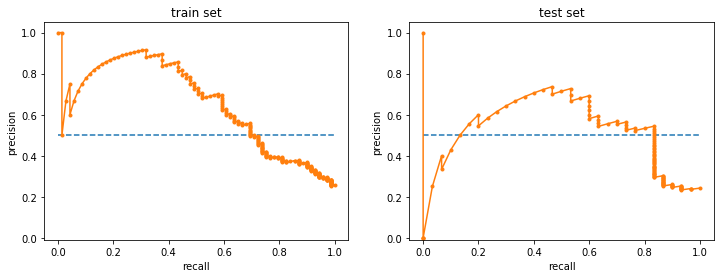

In [116]:
# plot precision-recall curve
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_precision_recall_curve(df_train_lr, title_addition='train set', ax=ax[0])
plot_precision_recall_curve(df_test_lr, title_addition='test set', ax=ax[1])
plt.show()

>Blue dot line is the baseline of PR curve.<br>
Test set AUC (area under PR curve) is 0.5195 and it is barely above baseline (0.5).

**Score Summary - Logistic Regression**

|CV(maxIter=10)|precison|recall|f1|AUC|AP|
|---|---|---|---|---|---|
|medium data train set|0.8333|0.4348|0.5714|0.6514|0.6570|
|medium data test set|0.5000|0.1333|0.2105|0.5195|0.5366|

>Test set score F1=0.2105 is not very satisfactory. Train set score F1=0.5714 is not high, eigher.<br>
This indicates under-fitting.<br>

(For further discussion by comparing with mini set result, please refer to mini set note.)

---
#### 2. Gradient Boosted-Tree Classifier

First, we try with default parameters.

In [108]:
# Gradient Boosted-Tree Classifier (training with default parameters)
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='label')

# pipeline with standard scaler
gbt_pipeline = Pipeline(stages=[stdScaler, gbt])

gbtModel = gbt_pipeline.fit(df_train)

In [109]:
# calculate metrics with training data
df_train_gbt = gbtModel.transform(df_train)
_ = calculate_metrics(
    'Gradient Boosted-Tree Classifier (train, default params)', df_train_gbt)

Gradient Boosted-Tree Classifier (train, default params)
precision:1.0000, recall:0.9710, f1:0.9853
(TP:67, TN:240, FP:0, FN:2)


In [110]:
# calculate metrics with test data
df_test_gbt = gbtModel.transform(df_test)
_ = calculate_metrics(
    'Gradient Boosted-Tree Classifier (test, default params)', df_test_gbt)

Gradient Boosted-Tree Classifier (test, default params)
precision:0.5882, recall:0.6667, f1:0.6250
(TP:20, TN:94, FP:14, FN:10)


>Test set score is F1=0.6250 and not so bad.<br>
While, train set score is F1=0.9853, and this gap indicates over-fitting.<br>
We try improving it by parameter tuning with grid search.

**Parameter Tuning - Gradient Boosted-Tree Classifier**<br>
We vary 'maxIter' parameter by grid search.

In [117]:
# grid search parameters
gbt_grid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 50]) \
    .build()

# evaluator
gbt_evaluator = BinaryClassificationEvaluator(
    metricName='areaUnderPR')  # precision-recall-curve

# grid search with 3 folds cross validation
gbt_cv = CrossValidator(estimator=gbt_pipeline,
                        estimatorParamMaps=gbt_grid,
                        evaluator=gbt_evaluator,
                        numFolds=3)

gbtModel = gbt_cv.fit(df_train)

In [118]:
# calculate metrics with training data
df_train_gbt = gbtModel.transform(df_train)
_ = calculate_metrics(
    'Gradient Boosted-Tree Classifier (train, grid-search)', df_train_gbt)

Gradient Boosted-Tree Classifier (train, grid-search)
precision:1.0000, recall:1.0000, f1:1.0000
(TP:69, TN:240, FP:0, FN:0)


In [119]:
# calculate metrics with test data
df_test_gbt = gbtModel.transform(df_test)
_ = calculate_metrics(
    'Gradient Boosted-Tree Classifier (test, grid-search)', df_test_gbt)

Gradient Boosted-Tree Classifier (test, grid-search)
precision:0.5938, recall:0.6333, f1:0.6129
(TP:19, TN:95, FP:13, FN:11)


In [120]:
# save the best pipeline to a folder
gbtModel.bestModel.write().overwrite().save('gbtModel')

In [121]:
# extract the best model parameters
bestGbtClassifier = gbtModel.bestModel.stages[-1]
bestGbtClassifier.extractParamMap()

{Param(parent='GBTClassifier_4b25b5b00cda06ae4a42', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_4b25b5b00cda06ae4a42', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='GBTClassifier_4b25b5b00cda06ae4a42', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256,
 Param(parent='GBTClassifier_4b25b5b00cda06ae4a42', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0,
 Param(parent='GBTClassifier_4b25b5b00cda06ae4a42', name='seed', doc='random seed'): 1774859733893788419,
 Param(parent='GBTClassifier_4b25b5b00cda06ae4a42', name='predictio

>The best model train set score is F1=1.0 and test score is F1=0.6129 with 'maxIter'=50.<br>
Grid search did not improve scores, but the best model score should be more stable after going through cross validation process.

We plot precision-recall curve.

F1=1.0000, AUC=1.0000, AP=1.0000 train set
F1=0.6129, AUC=0.6253, AP=0.6333 test set


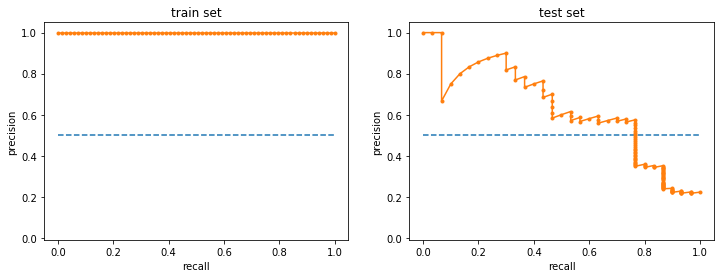

In [122]:
# plot precision-recall curve
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_precision_recall_curve(df_train_gbt, title_addition='train set', ax=ax[0])
plot_precision_recall_curve(df_test_gbt, title_addition='test set', ax=ax[1])
plt.show()

>Test set AUC is 0.6253 and it is above baseline (0.5).

**Score Summary - Gradient Boosted-Tree Classifier**

|CV(maxIter=50)|precison|recall|f1|AUC|AP|
|---|---|---|---|---|---|
|medium data train set|1.0000|1.0000|1.0000|1.0000|1.0000|
|medium data test set|0.5938|0.6333|0.6129|0.6253|0.6333|

>Train set score F1=1.0 definitely indicates over-fitting. But test set score F1=0.6129 is pretty good.<br>

(For further discussion by comparing with mini set result, please refer to mini set note.)

**Feature Importances**<br>
Feature importances can be extracted from Gradient Boosted-Tree model.

In [123]:
# load trained Gradient Boosted-Tree Classifier model from folder
saved_gbtModel = PipelineModel.load('gbtModel')

# get the best model and its feature importances
bestGbtModel = saved_gbtModel.stages[-1]
feature_importances = bestGbtModel.featureImportances.toArray()
feature_importances

array([ 0.28185369,  0.10279969,  0.06136328,  0.08890626,  0.02677792,
        0.05879448,  0.04574247,  0.02473714,  0.01321258,  0.02455085,
        0.0397913 ,  0.01683182,  0.03992177,  0.05713802,  0.04833578,
        0.04194331,  0.01769198,  0.00960767])

In [124]:
# change feature_labels to numpy array
feature_labels_arr = np.array(feature_labels)
feature_labels_arr

array(['songInterval', 'paidRatio', 'About', 'Add_Friend',
       'Add_to_Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout',
       'Roll_Advert', 'Save_Settings', 'Settings', 'Submit_Downgrade',
       'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 'Upgrade'],
      dtype='<U16')

In [125]:
# sort feature importances and get indices
sorted_indices = np.argsort(feature_importances)[::-1]

# get sorted importance list and label list
sorted_labels = feature_labels_arr[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# scale to max value
sorted_importances = sorted_importances / np.max(sorted_importances)

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


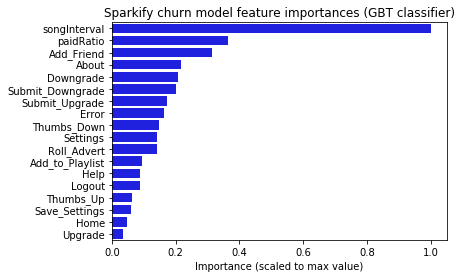

In [126]:
# plot feature importances (Gradient Boosted-Tree Classifier)
sns.barplot(x=sorted_importances, y=sorted_labels, orient='h', color='blue')
plt.title('Sparkify churn model feature importances (GBT classifier)')
plt.xlabel('Importance (scaled to max value)')
plt.show()

>'songInterval' (song inteval) is the most important feature for the Gradient Boosted-Tree model with medium data set.<br>

(For further discussion by comparing with mini set result, please refer to mini set note.)